In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd /content/drive/My\ Drive/Mask&NoMask

/content/drive/My Drive/Mask&NoMask


In [35]:
import numpy as np
import cv2
from keras.applications import MobileNetV2
from keras.applications.vgg16 import VGG16
from keras.regularizers import l2 # for model
from keras.layers import Input,Conv2D,Dense, Dropout, BatchNormalization, MaxPooling2D, Activation, Flatten, AvgPool2D,InputLayer
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.vgg16 import preprocess_input as vgg16_pre
from keras.applications.vgg19 import preprocess_input as vgg19_pre
from keras.applications.xception import preprocess_input as xcep_pre
from keras.layers import  BatchNormalization as btn
from keras.models import Model, Sequential
from keras.applications.resnet50 import ResNet50
from keras.initializers import glorot_normal
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.callbacks import LearningRateScheduler
from keras.layers.pooling import  AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import RMSprop, Adam
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt
from glob import glob 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle


In [4]:
def unpickle(filepath):
  with open(filepath, 'rb') as f:
    return pickle.load(f)

In [5]:
def processing_image(filepath):
  img = cv2.imread(filepath, cv2.IMREAD_COLOR)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return cv2.resize(img_rgb, (224,224), cv2.INTER_CUBIC)

In [ ]:
DATASET_PATH = os.path.join(os.getcwd(), 'dataset')
folder = ['with_mask', 'without_mask']

In [ ]:
for fol_name in folder:
  count=0
  for i,file_name in enumerate(glob(os.path.join(DATASET_PATH,fol_name,"**","*.jpg"), recursive=True)):
    count+=1
  print(f"No. of Images {fol_name} -> {count} ")

No. of Images with_mask -> 690 
No. of Images without_mask -> 686 


In [ ]:
X = np.zeros((1376,224,224,3), dtype=np.float32)
y = np.zeros((1376,2), dtype=np.uint8) 
j = int(0)

for fol_name in folder:
  # print(fol_name)
  for i,file_name in tqdm(enumerate(glob(os.path.join(DATASET_PATH,fol_name,"**","*jpg"), recursive=True))):
    assert file_name != ''

    img = processing_image(file_name)
    X[j,:] = np.squeeze(img.reshape((224,224,3)) )

    if( fol_name == 'with_mask'):
      y[j,1] = 1
    else:
      y[j,0] = 1

    j+=1


690it [05:38,  2.04it/s]
686it [05:14,  2.18it/s]


In [7]:
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (1376, 224, 224, 3)
Shape of y: (1376, 2)


In [12]:
X = unpickle('data.pkl')
y = unpickle('output.pkl')

In [ ]:
pickle.dump(X, open('data.pkl', 'wb'))
pickle.dump(y, open('output.pkl', 'wb'))

In [ ]:
np.argmax(y[345], axis=0)

1

(-0.5, 223.5, 223.5, -0.5)

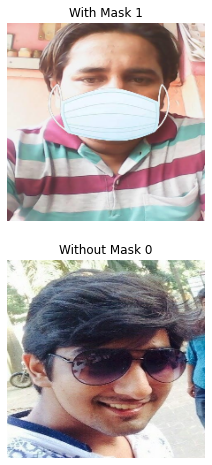

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.imshow(X[345].astype(np.uint8))
plt.title(f"With Mask {np.argmax(y[345],axis=0)}")
plt.axis('off')

plt.subplot(212)
plt.imshow(X[1300].astype(np.uint8))
plt.title(f"Without Mask {np.argmax(y[1300],axis=0)}")
plt.axis('off')

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=243)

print(f"X_train:  {X_train.shape}")
print(f"y_train:  {y_train.shape}")
print(f"X_val:  {X_val.shape}")
print(f"y_test:  {y_val.shape}")

X_train:  (1100, 224, 224, 3)
y_train:  (1100, 2)
X_val:  (276, 224, 224, 3)
y_test:  (276, 2)


In [14]:
# Checking the Distribution of Mask and Non mask photos in training and 
# Validation data.

with_mask = int(0)
without_mask = int(0)

for x in range(y_train.shape[0]):
  if np.argmax(y_train[x], axis=0)==1:
    with_mask += 1
  else:
    without_mask += 1

print("For training Data")
print(f"Without_mask:  {without_mask}")
print(f"With_mask: {with_mask}")
print("=="*20)

with_mask = 0
without_mask = 0

for x in range(y_val.shape[0]):
  if np.argmax(y_val[x], axis=0)==1:
    with_mask += 1
  else:
    without_mask += 1

print("For Testing Data")
print(f"Without_mask:  {without_mask}")
print(f"With_mask: {with_mask}")



For training Data
Without_mask:  550
With_mask: 550
For Testing Data
Without_mask:  136
With_mask: 140


In [15]:
# Small Custom Test Data for Mask And Non Mask Images
X_test = np.zeros((12,224,224,3), dtype=np.float32)
y_test = np.zeros((12,2), dtype=np.uint8)
TEST_DATASET = os.path.join(os.getcwd(),'Test Data')
folder = ['Mask', 'NonMask']
m = int(0)

for fol_name in folder:
  for i,file_name in tqdm(enumerate(glob(os.path.join(TEST_DATASET,fol_name,"**","*jpg"), recursive=True))):

    img = processing_image(file_name)
    # print(img.shape)
    X_test[m,:] = np.squeeze(img.reshape((224,224,3)) )

    if( fol_name == 'Mask'):
      y_test[m,1] = 1
    else:
      y_test[m,0] = 1

    m+=1

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

6it [00:00, 246.38it/s]
6it [00:00, 278.93it/s]

X_test shape: (12, 224, 224, 3)
y_test shape: (12, 2)


In [11]:
for i in range(X_test.shape[0]):
  X[i,:] = preprocess_input(X_test[i])

print(X_test.shape)

(12, 224, 224, 3)


#**Image Datagenerator**

In [16]:
# Datagen for training images
traindatagen = ImageDataGenerator(
            zoom_range = 0.2,
            shear_range = 0.2,
            horizontal_flip = True,
            fill_mode='nearest',
            rotation_range=20
)

In [17]:
# Datagenerator for validation images
valdatagen = ImageDataGenerator(
            zoom_range = 0.2,
            shear_range = 0.2,
            horizontal_flip = True,
            fill_mode='nearest',
            rotation_range=20
)

In [ ]:
# checking the images generated by Train Image DataGenerator
img = X[1]
img = img[np.newaxis,:]
print(img.shape)
i = int(0)

for batch in traindatagen.flow(img, batch_size=1, save_to_dir='preview/', save_prefix='mask', save_format='jpeg'):
  i+=1
  if i>10:
    break


(1, 224, 224, 3)


In [18]:
# Creating the Generator For Train Data and Validation Data
train_generator = traindatagen.flow(X_train, y_train, batch_size=32, shuffle=False)
val_generator = valdatagen.flow(X_val, y_val, batch_size=32, shuffle=False)

#**MobileNet-V2 Transfer Learning**

In [ ]:
model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3) )

In [ ]:
# Not to train the layers again
for ly in model.layers:
  ly.trainable = False

In [ ]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
print(f'No. of Layers in MobileNet: {len(model.layers)}')

No. of Layers in MobileNet: 155


In [ ]:
# Prepreocess the Images so that it becomes compatible related to Input of the pretrained MobileNetV2 model.

for i,x in tqdm(enumerate(range(X_train.shape[0]))):
  X_train[i,:] = preprocess_input(X_train[i])


for j,x in tqdm(enumerate(range(X_val.shape[0]))):
  X_val[j,:] = preprocess_input(X_val[j])


1100it [00:00, 6069.53it/s]
276it [00:00, 6302.14it/s]


In [ ]:
# Checking the last layer of mobile net model
print(model.layers[-1])
print(model.layers[-1].output)

Tensor("out_relu/Relu6:0", shape=(None, 7, 7, 1280), dtype=float32)


In [ ]:
model.input

<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>

In [ ]:
mobile_output = model.layers[-1].output 

global_pooling  = GlobalAveragePooling2D()(mobile_output)
# flatten = Flatten()(global_pooling)
dense1 = Dense(512, activation='relu')(global_pooling)
drop1 = Dropout(0.5)(dense1)
dense2_out = Dense(2, activation='softmax')(drop1)

model1 = Model(model.input, dense2_out)


In [ ]:
optimizer_adam = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=None
history = model1.fit_generator(train_generator, steps_per_epoch=X_train.shape[0]//32, epochs=10,verbose=1, validation_data=val_generator,
                              shuffle=False)


Epoch 1/10
34/34 [==============================] - 22s 653ms/step - loss: 0.4873 - accuracy: 0.7665 - val_loss: 0.2994 - val_accuracy: 0.8442
Epoch 2/10
34/34 [==============================] - 16s 478ms/step - loss: 0.2119 - accuracy: 0.9242 - val_loss: 0.2320 - val_accuracy: 0.8986
Epoch 3/10
34/34 [==============================] - 16s 468ms/step - loss: 0.1449 - accuracy: 0.9522 - val_loss: 0.2401 - val_accuracy: 0.9130
Epoch 4/10
34/34 [==============================] - 16s 457ms/step - loss: 0.1262 - accuracy: 0.9541 - val_loss: 0.1687 - val_accuracy: 0.9601
Epoch 5/10
34/34 [==============================] - 15s 450ms/step - loss: 0.0938 - accuracy: 0.9700 - val_loss: 0.1115 - val_accuracy: 0.9457
Epoch 6/10
34/34 [==============================] - 15s 452ms/step - loss: 0.0853 - accuracy: 0.9728 - val_loss: 0.0733 - val_accuracy: 0.9819
Epoch 7/10
34/34 [==============================] - 15s 455ms/step - loss: 0.0843 - accuracy: 0.9710 - val_loss: 0.0360 - val_accuracy: 0.9928

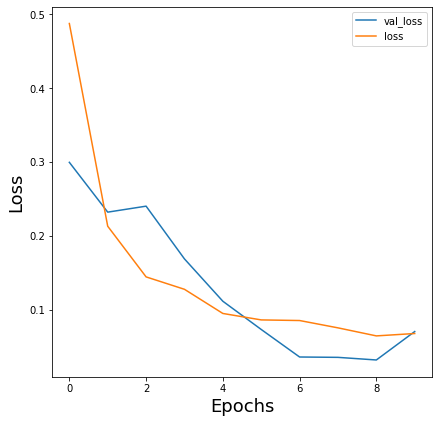

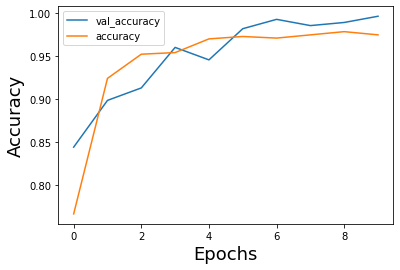

In [ ]:
name_title = ['Loss','Accuracy']
# for net in range(nets):
fig=plt.figure(figsize=(64,64))
for i in range(0,2):
    ax=fig.add_subplot(8,8,i+1)
    plt.plot(history.history[list(history.history.keys())[i]], label = list(history.history.keys())[i] )
    plt.plot(history.history[list(history.history.keys())[i+2]],label = list(history.history.keys())[i+2] )
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel(name_title[i], fontsize=18)
    plt.legend()
    plt.show()


In [ ]:
# Saving the Mobile Net Model
model1.save("Save_Model/model1_mobileNet.h5")

In [ ]:
# Testing Model On Test Data
predictions = np.argmax(model1.predict(X_test), axis=1)
print(f"Classification Report: \n {classification_report(np.argmax(y_test,axis=1), predictions)}")
print("\n")
print("=="*40)
print(f"Confusion Matrix: \n {confusion_matrix(np.argmax(y_test, axis=1), predictions)}")


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



Confusion Matrix: 
 [[6 0]
 [0 6]]


#**VGG16 Transfer Learning**

In [ ]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3) )

In [20]:
for ly in vgg16.layers:
  ly.trainable = False

In [21]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
# Prepreocess the Images so that it becomes compatible related to Input of the pretrained Vgg16 model.

for i,x in tqdm(enumerate(range(X_train.shape[0]))):
  X_train[i,:] = vgg16_pre(X_train[i])


for j,x in tqdm(enumerate(range(X_val.shape[0]))):
  X_val[j,:] = vgg16_pre(X_val[j])

1100it [00:00, 1737.19it/s]
276it [00:00, 1776.53it/s]


In [24]:
out = vgg16.layers[-1].output
global_avg = GlobalAveragePooling2D()(out)
dense1 = Dense(512, activation='relu')(global_avg)
drop1 = Dropout(0.5)(dense1)
dense2_out = Dense(2, activation='softmax')(drop1)

model2 = Model(vgg16.input, dense2_out)


In [25]:
optimizer = Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [26]:
history=None
history = model2.fit_generator(train_generator, steps_per_epoch=X_train.shape[0]//32, epochs=10,verbose=1, validation_data=val_generator,
                              shuffle=False)

Epoch 1/10
34/34 [==============================] - 24s 701ms/step - loss: 1.2587 - accuracy: 0.6820 - val_loss: 0.1259 - val_accuracy: 0.9565
Epoch 2/10
34/34 [==============================] - 16s 460ms/step - loss: 0.3474 - accuracy: 0.8998 - val_loss: 0.0225 - val_accuracy: 0.9891
Epoch 3/10
34/34 [==============================] - 16s 464ms/step - loss: 0.2006 - accuracy: 0.9401 - val_loss: 0.0061 - val_accuracy: 0.9891
Epoch 4/10
34/34 [==============================] - 15s 455ms/step - loss: 0.1548 - accuracy: 0.9551 - val_loss: 0.0055 - val_accuracy: 0.9891
Epoch 5/10
34/34 [==============================] - 15s 444ms/step - loss: 0.1041 - accuracy: 0.9625 - val_loss: 0.0052 - val_accuracy: 0.9891
Epoch 6/10
34/34 [==============================] - 15s 442ms/step - loss: 0.0866 - accuracy: 0.9710 - val_loss: 0.0226 - val_accuracy: 0.9855
Epoch 7/10
34/34 [==============================] - 15s 445ms/step - loss: 0.0929 - accuracy: 0.9766 - val_loss: 0.0034 - val_accuracy: 0.9964

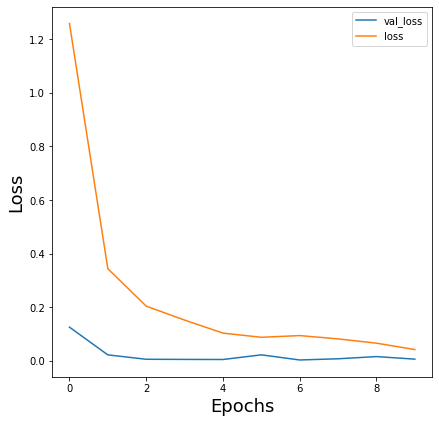

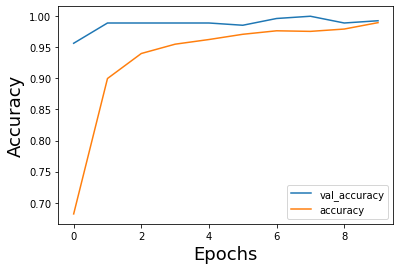

In [27]:
name_title = ['Loss','Accuracy']
# for net in range(nets):
fig=plt.figure(figsize=(64,64))
for i in range(0,2):
    ax=fig.add_subplot(8,8,i+1)
    plt.plot(history.history[list(history.history.keys())[i]], label = list(history.history.keys())[i] )
    plt.plot(history.history[list(history.history.keys())[i+2]],label = list(history.history.keys())[i+2] )
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel(name_title[i], fontsize=18)
    plt.legend()
    plt.show()


In [28]:
# Saving the Vgg16 model.
model2.save("Save_Model/model2_vgg16.h5")

In [29]:
for i in range(X_test.shape[0]):
  X_test[i,:] = vgg16_pre(X_test[i])

print(X_test.shape)

(12, 224, 224, 3)


In [30]:
# Testing Model On Test Data
predictions = np.argmax(model2.predict(X_test), axis=1)
print(f"Classification Report: \n {classification_report(np.argmax(y_test,axis=1), predictions)}")
print("\n")
print("=="*40)
print(f"Confusion Matrix: \n {confusion_matrix(np.argmax(y_test, axis=1), predictions)}")


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



Confusion Matrix: 
 [[6 0]
 [0 6]]


#**Xception Transfer Learning**

In [ ]:
xception = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3) )

In [32]:
for ly in xception.layers: 
  ly.trainable = False

In [34]:
xception.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [36]:
# Prepreocess the Images so that it becomes compatible related to Input of the pretrained Xception model.

for i,x in tqdm(enumerate(range(X_train.shape[0]))):
  X_train[i,:] = xcep_pre(X_train[i])


for j,x in tqdm(enumerate(range(X_val.shape[0]))):
  X_val[j,:] = xcep_pre(X_val[j])

1100it [00:00, 7177.11it/s]
276it [00:00, 6456.34it/s]


In [37]:
out = xception.layers[-1].output
global_avg = GlobalAveragePooling2D()(out)
dense1 = Dense(512, activation='relu')(global_avg)
drop1 = Dropout(0.5)(dense1)
dense2_out = Dense(2, activation='softmax')(drop1)

model3 = Model(xception.input, dense2_out)


In [38]:
optimizer = Adam(learning_rate=0.0001)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [39]:
history=None
history = model3.fit_generator(train_generator, steps_per_epoch=X_train.shape[0]//32, epochs=10,verbose=1, validation_data=val_generator,
                              shuffle=False)

Epoch 1/10
34/34 [==============================] - 20s 600ms/step - loss: 0.4512 - accuracy: 0.8327 - val_loss: 0.1794 - val_accuracy: 0.9529
Epoch 2/10
34/34 [==============================] - 17s 504ms/step - loss: 0.2115 - accuracy: 0.9494 - val_loss: 0.1480 - val_accuracy: 0.9601
Epoch 3/10
34/34 [==============================] - 17s 488ms/step - loss: 0.1443 - accuracy: 0.9654 - val_loss: 0.0495 - val_accuracy: 0.9819
Epoch 4/10
34/34 [==============================] - 16s 478ms/step - loss: 0.1183 - accuracy: 0.9663 - val_loss: 0.0426 - val_accuracy: 0.9819
Epoch 5/10
34/34 [==============================] - 16s 480ms/step - loss: 0.1001 - accuracy: 0.9719 - val_loss: 0.0454 - val_accuracy: 0.9710
Epoch 6/10
34/34 [==============================] - 16s 466ms/step - loss: 0.1006 - accuracy: 0.9644 - val_loss: 0.0360 - val_accuracy: 0.9710
Epoch 7/10
34/34 [==============================] - 16s 462ms/step - loss: 0.0816 - accuracy: 0.9719 - val_loss: 0.0132 - val_accuracy: 0.9783

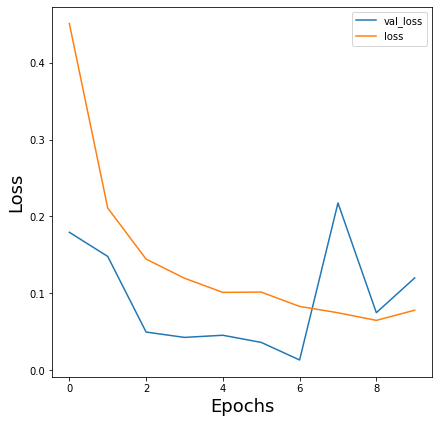

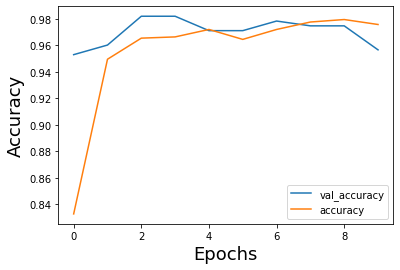

In [40]:
name_title = ['Loss','Accuracy']
# for net in range(nets):
fig=plt.figure(figsize=(64,64))
for i in range(0,2):
    ax=fig.add_subplot(8,8,i+1)
    plt.plot(history.history[list(history.history.keys())[i]], label = list(history.history.keys())[i] )
    plt.plot(history.history[list(history.history.keys())[i+2]],label = list(history.history.keys())[i+2] )
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel(name_title[i], fontsize=18)
    plt.legend()
    plt.show()


In [41]:
model3.save("Save_Model/model3_xception.h5")

In [42]:
for i in range(X_test.shape[0]):
  X_test[i,:] = xcep_pre(X_test[i])

print(X_test.shape)

(12, 224, 224, 3)


In [43]:
# Testing Model On Test Data
predictions = np.argmax(model3.predict(X_test), axis=1)
print(f"Classification Report: \n {classification_report(np.argmax(y_test,axis=1), predictions)}")
print("\n")
print("=="*40)
print(f"Confusion Matrix: \n {confusion_matrix(np.argmax(y_test, axis=1), predictions)}")


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



Confusion Matrix: 
 [[6 0]
 [0 6]]
